In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [17]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

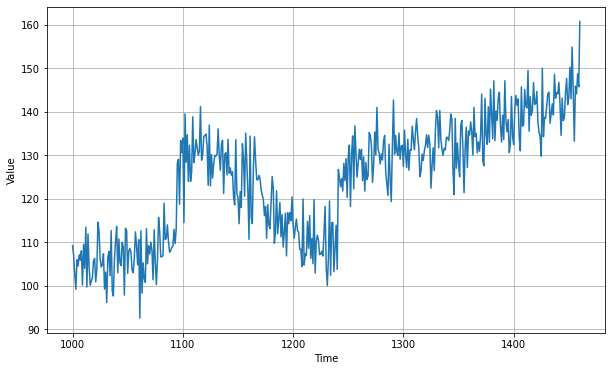

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [20]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense( 10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


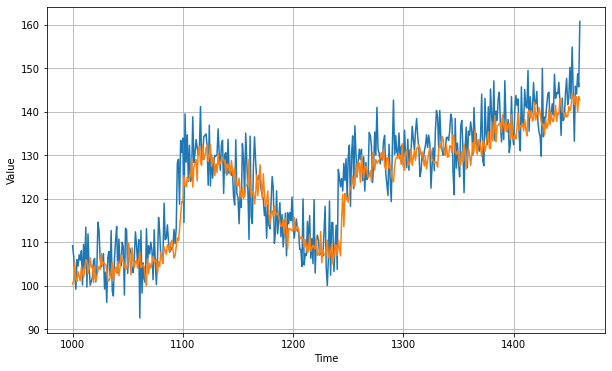

In [21]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7982397

In [23]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

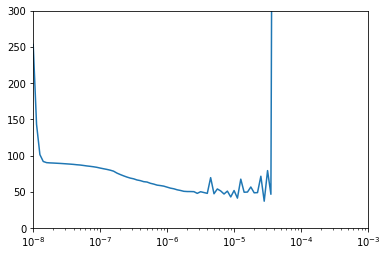

In [24]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [25]:
lrs

array([1.00000000e-08, 1.12201845e-08, 1.25892541e-08, 1.41253754e-08,
       1.58489319e-08, 1.77827941e-08, 1.99526231e-08, 2.23872114e-08,
       2.51188643e-08, 2.81838293e-08, 3.16227766e-08, 3.54813389e-08,
       3.98107171e-08, 4.46683592e-08, 5.01187234e-08, 5.62341325e-08,
       6.30957344e-08, 7.07945784e-08, 7.94328235e-08, 8.91250938e-08,
       1.00000000e-07, 1.12201845e-07, 1.25892541e-07, 1.41253754e-07,
       1.58489319e-07, 1.77827941e-07, 1.99526231e-07, 2.23872114e-07,
       2.51188643e-07, 2.81838293e-07, 3.16227766e-07, 3.54813389e-07,
       3.98107171e-07, 4.46683592e-07, 5.01187234e-07, 5.62341325e-07,
       6.30957344e-07, 7.07945784e-07, 7.94328235e-07, 8.91250938e-07,
       1.00000000e-06, 1.12201845e-06, 1.25892541e-06, 1.41253754e-06,
       1.58489319e-06, 1.77827941e-06, 1.99526231e-06, 2.23872114e-06,
       2.51188643e-06, 2.81838293e-06, 3.16227766e-06, 3.54813389e-06,
       3.98107171e-06, 4.46683592e-06, 5.01187234e-06, 5.62341325e-06,
      

In [26]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

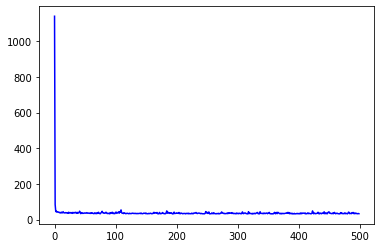

In [27]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[37.643028259277344, 41.953495025634766, 37.953697204589844, 38.077762603759766, 44.617828369140625, 38.8014030456543, 38.11845016479492, 37.24140548706055, 39.42034149169922, 38.25615692138672, 39.09480285644531, 35.8830680847168, 35.6786994934082, 41.333953857421875, 36.3955192565918, 39.529659271240234, 39.26121139526367, 36.090206146240234, 36.847984313964844, 40.36539840698242, 35.1209716796875, 39.35233688354492, 39.6547737121582, 37.329505920410156, 40.91763687133789, 39.62627410888672, 35.65376281738281, 40.891258239746094, 36.25218963623047, 36.90873718261719, 38.32780456542969, 47.197147369384766, 41.79605484008789, 33.554359436035156, 38.773582458496094, 38.716590881347656, 34.986717224121094, 35.91913986206055, 34.959251403808594, 37.15233612060547, 37.39889144897461, 36.00200271606445, 37.15863037109375, 39.04004669189453, 35.92800521850586, 36.10012435913086, 36.75871276855469, 34.806053161621094, 36.39728546142578, 34.638328552246094, 38.17034149169922, 35.10515975952148

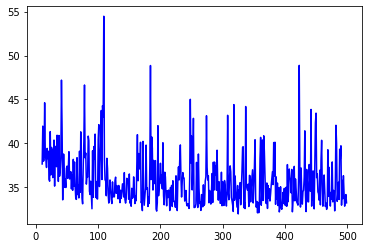

In [28]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

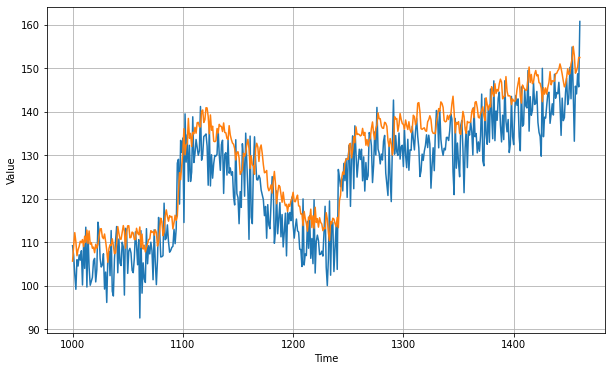

In [29]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.5714464